# Regional Interpretation of Well-Being
**Student:** Bakhtiyor Sohibnazarov  
**Student Number:** Z22590018  
**Module:** Data Visualization   
**Date Updated:** January 5, 2026

## 1. Importing Libraries
Installs and imports required libraries used in this notebook

In [1]:
# Run this block to install required libraries if missing. (Convert to code cell)   
!pip -q install pandas numpy matplotlib seaborn scikit-learn

In [2]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Prepare directories
os.makedirs("dataset/output", exist_ok=True)
os.makedirs("assets/appendix", exist_ok=True)
os.makedirs("assets/eda", exist_ok=True)
os.makedirs("assets/rq1", exist_ok=True)
os.makedirs("assets/rq2", exist_ok=True)
os.makedirs("assets/rq3", exist_ok=True)

# Load initial dataset. CHANGE PATH WHEN NECESSARY!
df = pd.read_csv("world-happiness-report.csv")
df.head().to_html("assets/appendix/df_raw.html", border=1, classes="table-style")
df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


##### Utilities & constants

Defines shared lists, plotting and stats helpers used across analysis cells.

In [3]:
# Shared constants
PREDICTORS = ["GDP", "SocialSupport", "Health", "Freedom", "Generosity"]
PREDICTORS_RQ3 = ["GDP", "SocialSupport", "Health", "Freedom"]
FOCUS_REGIONS = ["Europe", "Africa", "Asia", "North America", "South America"]

N_BINS = 15
MIN_YEARS = 3
DEFAULT_DPI = 300

# Set Global Theme
sns.set_theme(style="white", palette="colorblind", context="notebook")

# Robust save helper: accepts Figure or pyplot module
def save_fig(path, dpi=DEFAULT_DPI):
    plt.savefig(path, dpi=dpi, bbox_inches="tight")

# Small stats helpers
def fit_lr(X, y):
    return LinearRegression().fit(X, y)

def variance_reduction(res_base, res_new):
    vb = res_base.var()
    vn = res_new.var()
    return (vb - vn) / vb if vb > 0 else np.nan

def region_stats_from_residuals(df, resid_col="Residual"):
    return df.groupby("Region").agg(
        Mean_Residual=(resid_col, "mean"),
        Std_Residual=(resid_col, "std"),
        Percent_Positive=(resid_col, lambda x: (x > 0).mean() * 100),
        Count=(resid_col, "size")
    ).sort_values("Mean_Residual", ascending=False)

# Print Palette information
print("Colorblind friendly palette has been chosen for accessability")
sns.color_palette("colorblind")

Colorblind friendly palette has been chosen for accessability


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## 2. Data Preparation
### 2.1 Cleanup

Rename cols for easier analysis. Positive and Negative affect cols wont be analyzed in this pipline and should be removed to make dataset compact. This is because Postive and Negative affect data is collected using survey of different people over short amount of time, it may distort results on the long run

In [4]:
# Rename original columns to standardised names
df = df.rename(columns={
    "Country name": "Country",
    "year": "Year",
    "Life Ladder": "Happiness",
    "Log GDP per capita": "GDP",
    "Social support": "SocialSupport",
    "Healthy life expectancy at birth": "Health",
    "Freedom to make life choices": "Freedom",
    "Perceptions of corruption": "Corruption"
})

# Drop cols
df = df.drop(columns=["Positive affect", "Negative affect"], errors="ignore")
df.head().to_html("assets/appendix/df_prep.html", border=1, classes="table-style")
df.head()

,Country,Year,Happiness,GDP,SocialSupport,Health,Freedom,Generosity,Corruption
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776


### 2.2 Year Continuity Check
As above preview, initial dataset contains country level life quality analysis results over some years but whether it is complete and consistent is unclear. Before analysis temporal coverage should be checked to make dataset consistent for analysis

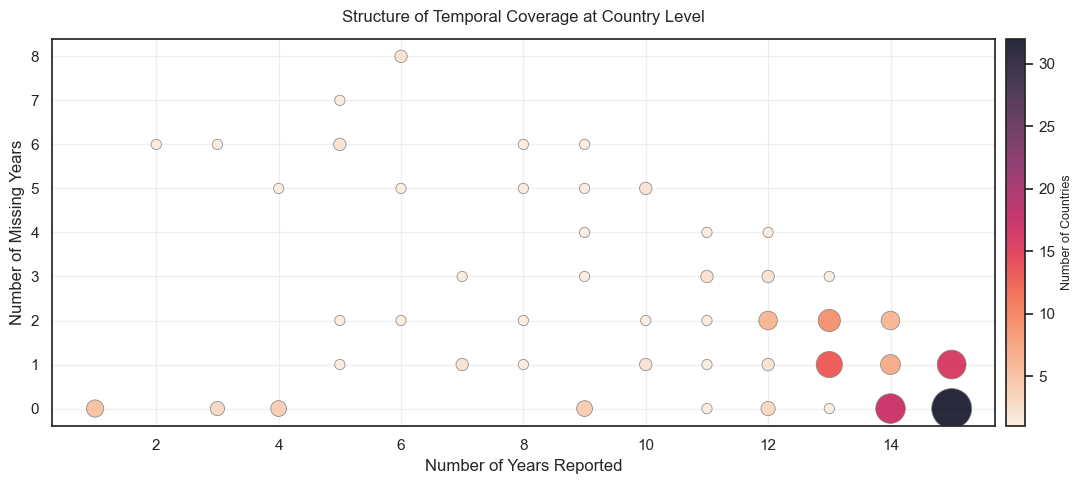

In [5]:
# Compute temporal coverage
coverage = (
    df.groupby("Country")["Year"]
      .agg(YearsReported="nunique", YearMin="min", YearMax="max")
      .assign(
          MissingYears=lambda x: (x["YearMax"] - x["YearMin"] + 1) - x["YearsReported"]))

# Aggregate to unique coverage patterns
coverage_counts = (coverage.groupby(["YearsReported", "MissingYears"]).size().reset_index(name="Count"))

# Bubble chart of temporal coverage
fig, ax = plt.subplots(figsize=(12, 5))
scatter = ax.scatter(
    coverage_counts["YearsReported"],
    coverage_counts["MissingYears"],
    s=30 + coverage_counts["Count"] * 25,
    c=coverage_counts["Count"],
    cmap="rocket_r",
    alpha=0.85,
    edgecolors="grey",
    linewidth=0.6
)

# Labels & styling
ax.set_title("Structure of Temporal Coverage at Country Level", fontsize=12, pad=12)
ax.set_xlabel("Number of Years Reported")
ax.set_ylabel("Number of Missing Years")
ax.grid(True, alpha=0.3)
ax.set_axisbelow(True)

# Colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.01)
cbar.set_label("Number of Countries", fontsize=9)

# Finalise
plt.tight_layout()
save_fig("assets/eda/country_year_coverage_density.png")
plt.show()

### 2.3 Consistency Filtering
Above figure shows that countries report different years. some of them total 15 years and some are only 1 year. The best logical medium is 3 years as this gives enough temporal coverage to fill potential missing data in the future without fabrication

In [6]:
# Consistency: use MIN_YEARS from helpers (defined earlier)
years = np.sort(df["Year"].unique())

# Optimal contiguous window (uses centralized MIN_YEARS)
windows = [(years[i], years[i + MIN_YEARS - 1])
           for i in range(len(years) - MIN_YEARS + 1)]

best_start, best_end = max(
    windows,
    key=lambda w: df[
        df["Year"].between(*w)
    ].groupby("Country")["Year"].nunique().ge(MIN_YEARS).sum()
)

# Lock window & enforce consistency
df_window = df[df["Year"].between(best_start, best_end)]
df_balanced = df_window.groupby("Country").filter(
    lambda x: x["Year"].nunique() >= MIN_YEARS
)

# Summary
print(f"Best window: {best_start}–{best_end}")

Best window: 2015–2017


### 2.4 Check missing data
Interpolation should be done on already locked dataset. Missing data will be checked before filling missing values, this prevents filling dataset blindly

In [7]:
# Check missing data by grouping
missing_by_country_var = (df_balanced.set_index(["Country", "Year"]).isna().groupby("Country").sum())

# Display
missing = missing_by_country_var[missing_by_country_var.sum(axis=1) > 0]
missing.to_html("assets/appendix/missing_raw.html", border=1, classes="table-style")
missing

,Happiness,GDP,SocialSupport,Health,Freedom,Generosity,Corruption
Country,,,,,,,
Bahrain,0,0,0,0,0,0,3
China,0,0,0,0,2,0,3
Egypt,0,0,0,0,0,0,1
Jordan,0,0,0,0,0,0,3
Kosovo,0,0,0,3,0,0,0
Kuwait,0,0,0,0,0,0,3
Libya,0,0,0,0,0,0,2
Palestinian Territories,0,0,0,3,0,0,0
Saudi Arabia,0,0,0,0,0,0,3


### 2.5 Further Cleaning and Interpolation
Extreme missingness cannot be filled further, fabricated data will corrupt dataset. Remaining NaNs should be handled during analysis but extreme missingness should be removed in order to make dataset as much clean as possible. Therefore Corruption col and South Sudan can be removed to minimize missing data and stabilize GDP col respectively

In [8]:
# Final cleaning decisions
# Remove country with structural GDP/Generosity gaps
df_balanced = df_balanced[df_balanced["Country"] != "South Sudan"].copy()

# Drop corruption due to systemic regional missingness
df_balanced = df_balanced.drop(columns=["Corruption"], errors="ignore")

# Within-country interpolation (time-aware)
df_balanced = df_balanced.sort_values(["Country", "Year"]).reset_index(drop=True)

df_balanced[PREDICTORS] = (
    df_balanced.groupby("Country")[PREDICTORS]
    .transform(lambda s: s.interpolate(method="linear", limit_direction="both"))
)

# Audit excluded countries
countries_original = set(df["Country"].unique())
countries_final = set(df_balanced["Country"].unique())

excluded_countries = countries_original - countries_final
df_excluded = df[df["Country"].isin(excluded_countries)].copy()

# Save artefacts
df_excluded.to_csv("dataset/output/excluded.csv", index=False)
df_excluded.to_html("assets/appendix/excluded_countries.html", border=1, classes="table-style")
df_balanced.to_csv("dataset/output/world_happiness_final.csv", index=False)
df_balanced.to_html("assets/appendix/preprocessed_dataset.html", border=1, classes="table-style")

# Final summary
print("=== Final Dataset Summary ===")
print(f"Countries before preprocessing: {len(countries_original)}")
print(f"Countries after preprocessing:  {len(countries_final)}")
print(f"Excluded countries: {len(excluded_countries)}")

# Diagnostic: remaining missingness (should be empty or minimal)
missing_by_country = df_balanced.isna().groupby(df_balanced["Country"]).sum()
interpolated = missing_by_country[missing_by_country.sum(axis=1) > 0]
interpolated.to_html("assets/appendix/missing_interpolated.html", border=1, classes="table-style")
interpolated

=== Final Dataset Summary ===
Countries before preprocessing: 166
Countries after preprocessing:  134
Excluded countries: 32


,Country,Year,Happiness,GDP,SocialSupport,Health,Freedom,Generosity
Country,,,,,,,,
Kosovo,0,0,0,0,0,3,0,0
Palestinian Territories,0,0,0,0,0,3,0,0
Taiwan Province of China,0,0,0,0,0,3,0,0


---
## 3. Exploratory Data Analysis
To gain an initial understanding of the structure, behaviour, and relationships within the preprocessed World Happiness dataset, EDA will be done. The goal of this phase is to extract patterns, distributions and connections which may give potential research tensions that will formulate into questions later

### 3.1 Univariate Exploration

Explore independent attributes separately, high level overview of the attributes

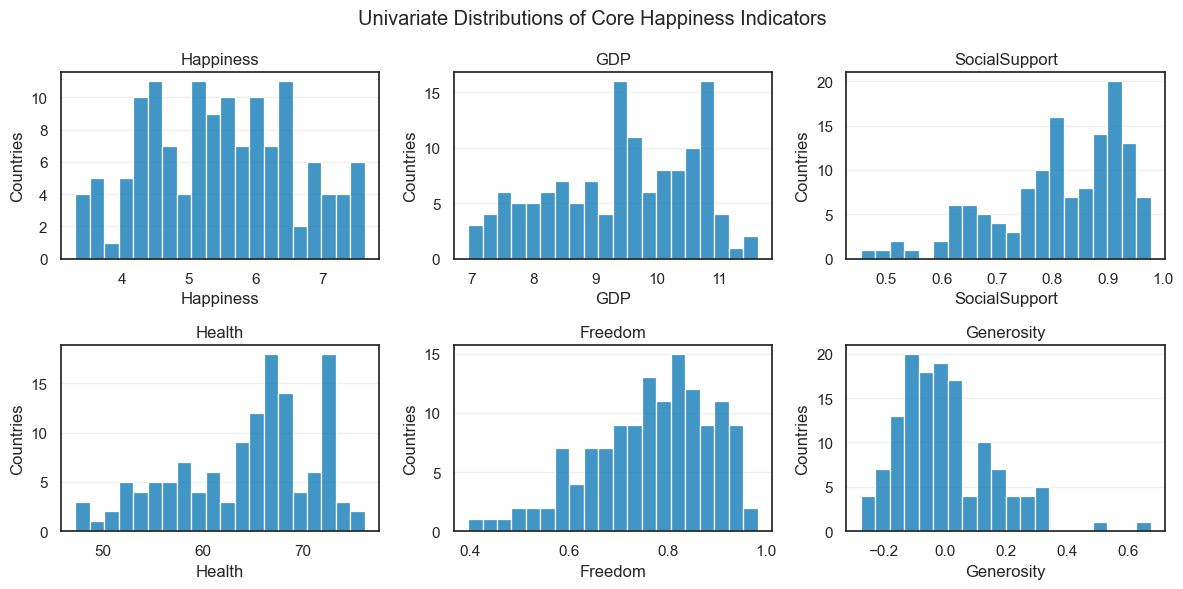

In [9]:
# Univariate distributions
univariate_cols = ["Happiness"] + PREDICTORS

# Country-level averaging (balanced window)
df_country = (df_balanced.groupby("Country", as_index=False)[univariate_cols].mean())

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()[:len(univariate_cols)]

for ax, col in zip(axes, univariate_cols):
    sns.histplot(df_country[col], bins=20, ax=ax)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Countries")
    ax.grid(True, axis="y", alpha=0.3)

plt.suptitle("Univariate Distributions of Core Happiness Indicators")
plt.tight_layout()
save_fig("assets/eda/univariate_distribution.png")
plt.show()

**Happiness** - Most scores cluster between 4–7. Extreme ratings are rare.

**GDP & Health** - Show large global inequality—some countries are vastly richer and healthier.

**Social Support & Freedom** - Reported levels are high and more evenly spread, even amid economic gaps.

**Generosity** - Most countries cluster near zero, with a few showing high generosity—a skewed distribution.

**Key Insight** - These predictors reflect distinct inequalities: GDP shows economic divides, while generosity reflects cultural disparities.

### 3.2 Bivariate Exploration

Observation of Happiness vs economic attributes

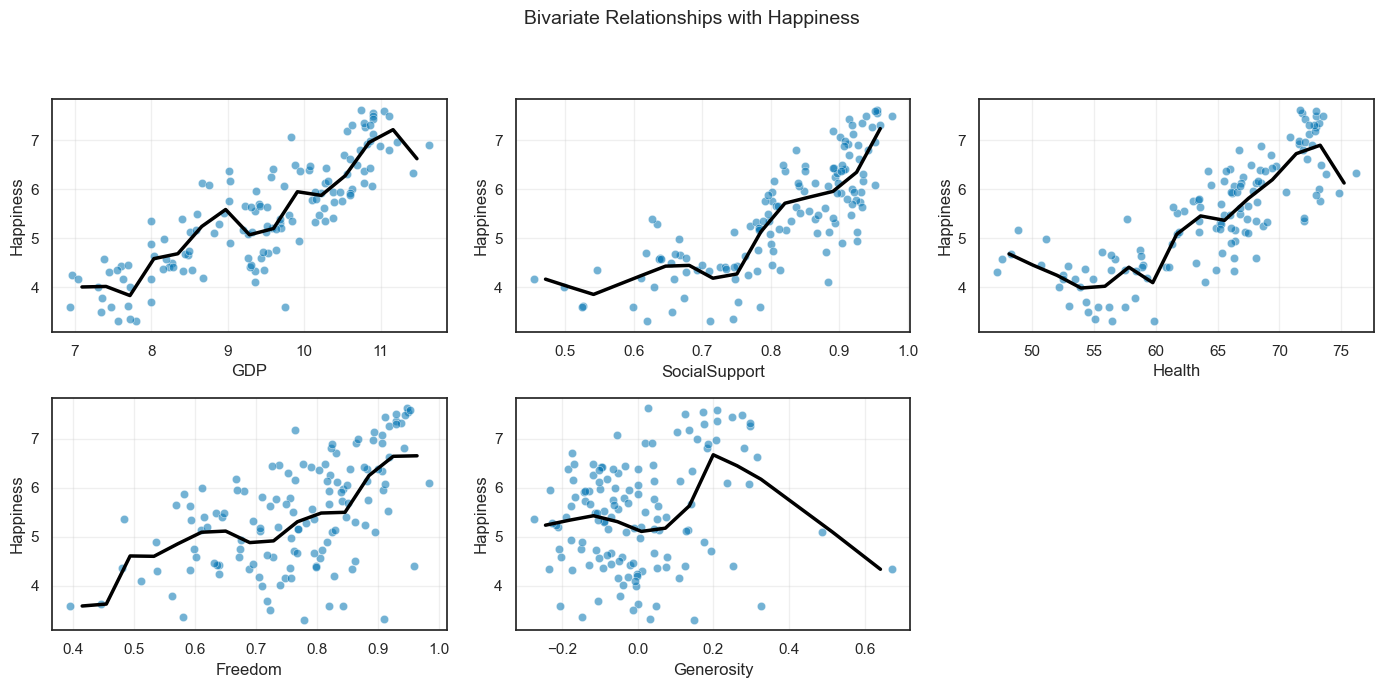

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes = axes.flatten()

for ax, col in zip(axes, PREDICTORS):
    sns.scatterplot(
        x=df_country[col],
        y=df_country["Happiness"],
        ax=ax,
        alpha=0.55
    )

    bins = pd.cut(df_country[col], bins=N_BINS)
    bin_means = (df_country.groupby(bins, observed=True)["Happiness"].mean().dropna() )

    x_centres = np.array([interval.mid for interval in bin_means.index])
    ax.plot(x_centres, bin_means.values, linewidth=2.5, color="black")
    ax.grid(True, alpha=0.3)

# REMOVE UNUSED AXES
for ax in axes[len(PREDICTORS):]:
    fig.delaxes(ax)

fig.suptitle("Bivariate Relationships with Happiness", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
save_fig("assets/eda/bivariate_distribution.png")
plt.show()

<table style="margin-left: 0; text-align: left; width: 100%;">
  <tr style="background-color: #f2f2f2;">
    <th style="padding: 8px; text-align: left;">Relationship</th>
    <th style="padding: 8px; text-align: left;">Key Observation</th>
  </tr>
  <tr>
    <td style="padding: 8px;">Happiness ~ GDP</td>
    <td style="padding: 8px;">Richer countries tend to be happier, but at similar wealth levels happiness varies widely</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Happiness ~ Social Support</td>
    <td style="padding: 8px;">The most consistent predictor of happiness across countries</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Happiness ~ Health</td>
    <td style="padding: 8px;">Similar to GDP, but with a slightly tighter relationship</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Happiness ~ Freedom</td>
    <td style="padding: 8px;">High freedom does not guarantee high happiness; the pattern is irregular</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Happiness ~ Generosity</td>
    <td style="padding: 8px;">Little to no clear relationship with happiness</td>
  </tr>
</table>

**The bottom line**

Economy and health matter for happiness, but not everywhere the same way. Meanwhile, strong social ties help the most, while freedom and generosity show no clear pattern.

**Key takeaway**
Happiness depends on how a country's wealth and health combine with its social connections—and this mix varies from place to place.

### 3.3 The Unexplained Variation
Can countries with same economic indicators show different level of Happiness?

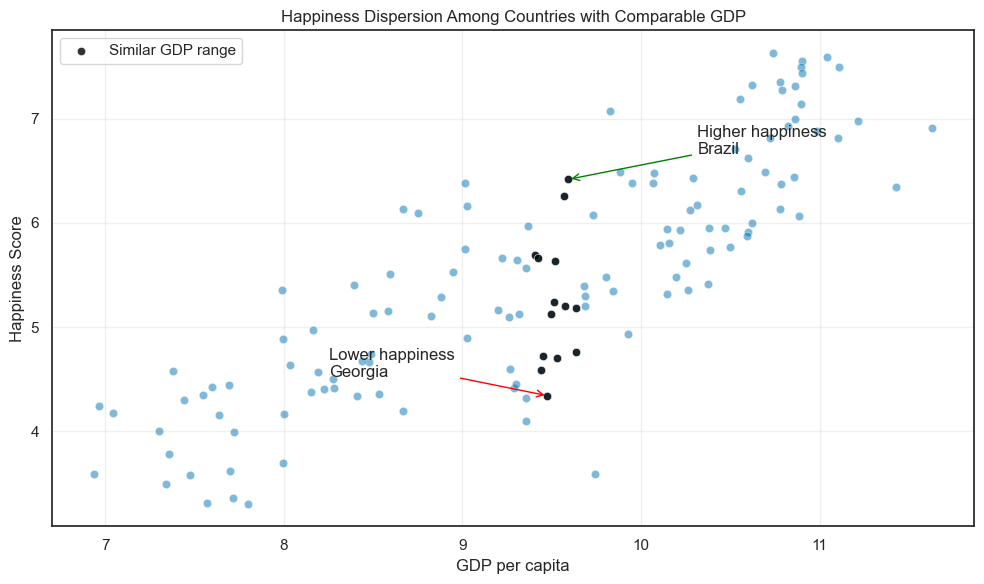

In [11]:
# Select countries with similar GDP (middle 10% band)
gdp_low = df_country["GDP"].quantile(0.45)
gdp_high = df_country["GDP"].quantile(0.55)

similar_gdp = df_country[
    (df_country["GDP"] >= gdp_low) &
    (df_country["GDP"] <= gdp_high)
]

# Identify extremes within this GDP band
high_happy = similar_gdp.nlargest(1, "Happiness")
low_happy = similar_gdp.nsmallest(1, "Happiness")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=df_country,
    x="GDP",
    y="Happiness",
    ax=ax,
    alpha=0.5
)

# Highlight similar-GDP band
sns.scatterplot(
    data=similar_gdp,
    x="GDP",
    y="Happiness",
    ax=ax,
    color="black",
    alpha=0.8,
    label="Similar GDP range"
)

# Annotate extremes
ax.annotate(
    f"Higher happiness\n{high_happy['Country'].iloc[0]}",
    xy=(high_happy["GDP"].iloc[0], high_happy["Happiness"].iloc[0]),
    xytext=(0.7, 0.75),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", color="green")
)

ax.annotate(
    f"Lower happiness\n{low_happy['Country'].iloc[0]}",
    xy=(low_happy["GDP"].iloc[0], low_happy["Happiness"].iloc[0]),
    xytext=(0.3, 0.3),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", color="red")
)

# Labels & styling
ax.set_title("Happiness Dispersion Among Countries with Comparable GDP")
ax.set_xlabel("GDP per capita")
ax.set_ylabel("Happiness Score")
ax.grid(True, alpha=0.3)

plt.legend()
plt.tight_layout()
save_fig("assets/eda/happiness_variation.png")
plt.show()

At roughly the same income level, some countries score around 7 while others fall closer to 4.0, a difference large enough to raise a question, **does countries in same region tend to report same happiness because of their cultural similarities?**

### 3.4 EDA Synthesis: Three Directions for Further Investigation
To answer above question, we will explore if data hints to natural clustering

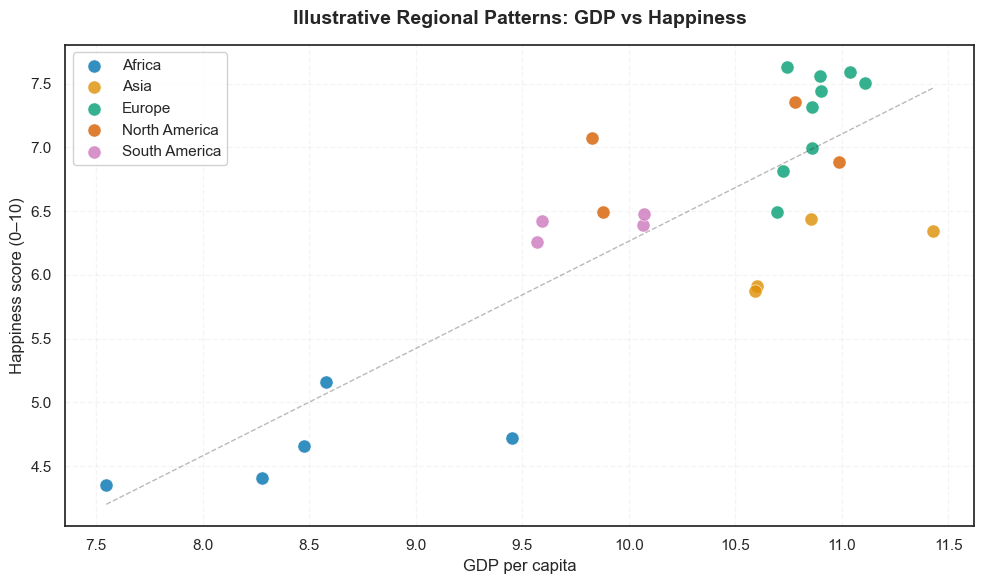

In [12]:
# Illustrative regional mapping (explicitly partial, EDA only)
continent_map = {
    # Europe
    'Finland': 'Europe', 'Denmark': 'Europe', 'Switzerland': 'Europe',
    'Netherlands': 'Europe', 'Sweden': 'Europe', 'Norway': 'Europe',
    'Germany': 'Europe', 'United Kingdom': 'Europe', 'France': 'Europe',

    # North America
    'United States': 'North America', 'Canada': 'North America',
    'Costa Rica': 'North America', 'Mexico': 'North America',

    # South America
    'Brazil': 'South America', 'Argentina': 'South America',
    'Chile': 'South America', 'Colombia': 'South America',

    # Asia
    'Japan': 'Asia', 'Taiwan Province of China': 'Asia',
    'Singapore': 'Asia', 'South Korea': 'Asia',

    # Africa
    'Nigeria': 'Africa', 'Ghana': 'Africa', 'Kenya': 'Africa',
    'South Africa': 'Africa', 'Ethiopia': 'Africa',
}

# Prepare illustrative subset only
df_sample = df_country[df_country["Country"].isin(continent_map.keys())].copy()
df_sample["RegionIllustrative"] = df_sample["Country"].map(continent_map)

# Plot: GDP vs Happiness (exploratory regional patterns)
fig, ax = plt.subplots(figsize=(10, 6))

for region in sorted(df_sample["RegionIllustrative"].unique()):
    subset = df_sample[df_sample["RegionIllustrative"] == region]
    ax.scatter(
        subset["GDP"],
        subset["Happiness"],
        label=region,
        s=90,
        alpha=0.8,
        edgecolor="white",
        linewidth=0.5
    )

# Global reference trend (visual guide only)
z = np.polyfit(df_sample["GDP"], df_sample["Happiness"], 1)
p = np.poly1d(z)
x_range = np.linspace(df_sample["GDP"].min(), df_sample["GDP"].max(), 100)
ax.plot(x_range, p(x_range), "k--", alpha=0.3, linewidth=1)

# Labels and framing
ax.set_title("Illustrative Regional Patterns: GDP vs Happiness", fontsize=14, fontweight="bold",pad=15)
ax.set_xlabel("GDP per capita")
ax.set_ylabel("Happiness score (0–10)")
ax.legend(loc="upper left", frameon=True, framealpha=0.9)
ax.grid(True, alpha=0.2, linestyle="--")

plt.tight_layout()
save_fig("assets/eda/regional_patterns_exploratory.png")
plt.show()

From above observations 3 distincs question can be proposed

| Observation from EDA | Question it naturally raises |
|----------------------|------------------------------|
| Geographic clustering in residuals | Do countries within the same geographic region show similar patterns in reported happiness, even when economic and social conditions are accounted for? |
| Predictors behave differently across groups |  Do key indicators affect happiness differently across world regions? |
| Persistent regional over- and under-performance | Are there regions that consistently report higher or lower happiness than their economic conditions would suggest? |

Together, these observations indicate that happiness is not shaped by single factors in isolation. Instead, it appears to be influenced by regional context, suggesting that economic indicators interact with social, cultural, and institutional factors in different ways across the world.


#### Region Division

Manually define regions for further analysis

In [13]:
# Define and divide to regions
region_map = {

    # Europe
    "United Kingdom": "Europe",
    "France": "Europe",
    "Germany": "Europe",
    "Italy": "Europe",
    "Spain": "Europe",
    "Portugal": "Europe",
    "Ireland": "Europe",
    "Netherlands": "Europe",
    "Belgium": "Europe",
    "Luxembourg": "Europe",
    "Switzerland": "Europe",
    "Austria": "Europe",
    "Norway": "Europe",
    "Sweden": "Europe",
    "Finland": "Europe",
    "Denmark": "Europe",
    "Iceland": "Europe",
    "Poland": "Europe",
    "Czech Republic": "Europe",
    "Slovakia": "Europe",
    "Hungary": "Europe",
    "Romania": "Europe",
    "Bulgaria": "Europe",
    "Greece": "Europe",
    "Ukraine": "Europe",
    "Belarus": "Europe",
    "Russia": "Europe",
    "Serbia": "Europe",
    "Croatia": "Europe",
    "Slovenia": "Europe",
    "Bosnia and Herzegovina": "Europe",
    "Montenegro": "Europe",
    "North Macedonia": "Europe",
    "Albania": "Europe",
    "Moldova": "Europe",
    "Lithuania": "Europe",
    "Latvia": "Europe",
    "Estonia": "Europe",
    "Malta": "Europe",
    "Cyprus": "Europe",
    "Kosovo": "Europe",

    # Asia
    "China": "Asia",
    "Japan": "Asia",
    "South Korea": "Asia",
    "India": "Asia",
    "Pakistan": "Asia",
    "Bangladesh": "Asia",
    "Nepal": "Asia",
    "Sri Lanka": "Asia",
    "Thailand": "Asia",
    "Vietnam": "Asia",
    "Philippines": "Asia",
    "Indonesia": "Asia",
    "Malaysia": "Asia",
    "Singapore": "Asia",
    "Mongolia": "Asia",
    "Hong Kong": "Asia",
    "Taiwan Province of China": "Asia",
    "Afghanistan": "Asia",
    "Armenia": "Asia",
    "Azerbaijan": "Asia",
    "Georgia": "Asia",
    "Kazakhstan": "Asia",
    "Kyrgyzstan": "Asia",
    "Tajikistan": "Asia",
    "Turkmenistan": "Asia",
    "Uzbekistan": "Asia",
    "Myanmar": "Asia",
    "Cambodia": "Asia",

    # Middle East
    "Turkey": "Middle East",
    "Israel": "Middle East",
    "Jordan": "Middle East",
    "Lebanon": "Middle East",
    "Saudi Arabia": "Middle East",
    "United Arab Emirates": "Middle East",
    "Qatar": "Middle East",
    "Kuwait": "Middle East",
    "Oman": "Middle East",
    "Bahrain": "Middle East",
    "Iran": "Middle East",
    "Iraq": "Middle East",
    "Yemen": "Middle East",
    "Palestinian Territories": "Middle East",
    "Libya": "Middle East",

    # Africa
    "South Africa": "Africa",
    "Nigeria": "Africa",
    "Ghana": "Africa",
    "Kenya": "Africa",
    "Ethiopia": "Africa",
    "Uganda": "Africa",
    "Tanzania": "Africa",
    "Zambia": "Africa",
    "Zimbabwe": "Africa",
    "Rwanda": "Africa",
    "Morocco": "Africa",
    "Algeria": "Africa",
    "Tunisia": "Africa",
    "Egypt": "Africa",
    "Benin": "Africa",
    "Botswana": "Africa",
    "Burkina Faso": "Africa",
    "Cameroon": "Africa",
    "Chad": "Africa",
    "Congo (Brazzaville)": "Africa",
    "Congo (Kinshasa)": "Africa",
    "Gabon": "Africa",
    "Guinea": "Africa",
    "Ivory Coast": "Africa",
    "Liberia": "Africa",
    "Madagascar": "Africa",
    "Malawi": "Africa",
    "Mali": "Africa",
    "Mauritania": "Africa",
    "Niger": "Africa",
    "Senegal": "Africa",
    "Sierra Leone": "Africa",
    "Togo": "Africa",

    # North America
    "United States": "North America",
    "Canada": "North America",
    "Mexico": "North America",
    "Costa Rica": "North America",
    "Dominican Republic": "North America",
    "El Salvador": "North America",
    "Guatemala": "North America",
    "Haiti": "North America",
    "Honduras": "North America",
    "Nicaragua": "North America",
    "Panama": "North America",

    # South America
    "Brazil": "South America",
    "Argentina": "South America",
    "Chile": "South America",
    "Colombia": "South America",
    "Peru": "South America",
    "Bolivia": "South America",
    "Ecuador": "South America",
    "Uruguay": "South America",
    "Paraguay": "South America",
    "Venezuela": "South America",

    # Oceania
    "Australia": "Oceania",
    "New Zealand": "Oceania"}

# Map to regions col
df_balanced["Region"] = df_balanced["Country"].map(region_map)

# Use centralized list for country-level aggregation
country_cols = ["Happiness"] + PREDICTORS

# Reset index
df_country = df_balanced.groupby(["Country", "Region"], as_index=False)[country_cols].mean()

# Print number of countries per region
df_country["Region"].value_counts()

Europe           41
Africa           32
Asia             25
Middle East      13
North America    11
South America    10
Oceania           2
Name: Region, dtype: int64

## RQ1: Do countries within the same geographic region show similar patterns in reported happiness, even when economic and social conditions are accounted for?

#### Motivation:
While economic indicators such as GDP are strongly linked to national happiness, they do not fully explain the variation observed between countries of comparable wealth. Countries with similar income levels can report markedly different levels of well-being.

This analysis investigates whether regional context—such as shared cultural, historical, or environmental factors—systematically influences how happiness is reported, beyond what is explained by economic and social variables.

##### Step 1: Establishing a Baseline Model of Happiness

This step builds a baseline happiness model using GDP, social support, health, freedom, and generosity as predictors. The model serves as a reference point, explaining how much happiness variation can be captured by these standard factors alone.

Baseline R² (no region): 0.804


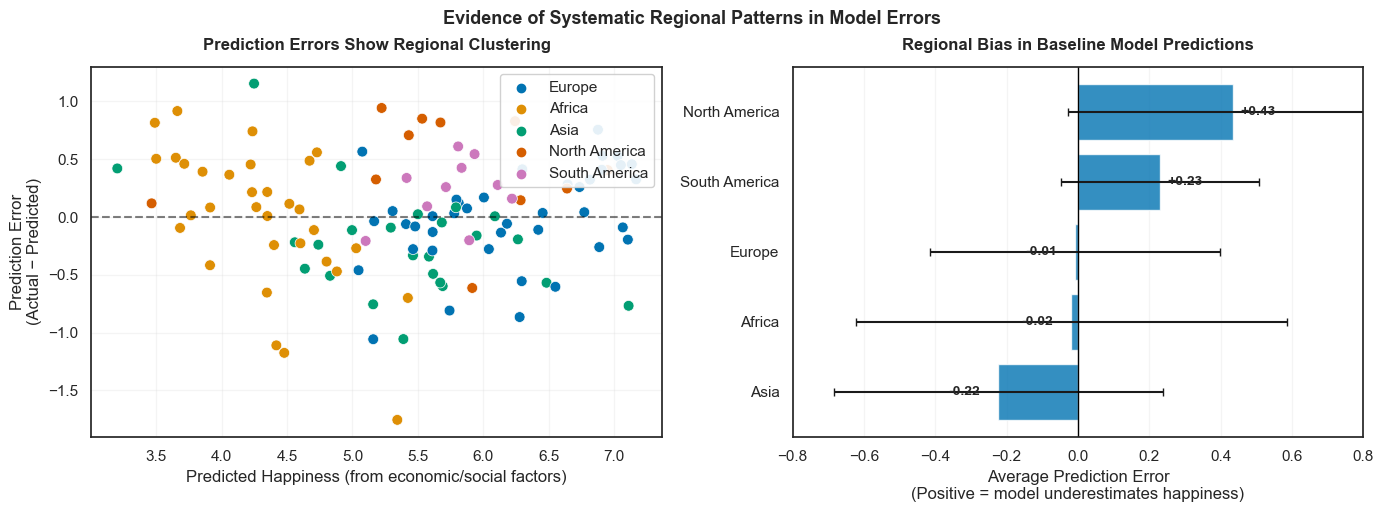

In [14]:
# Create clean dataframe
df_country_clean = df_country.dropna(subset=PREDICTORS + ["Happiness", "Region"]).copy()

# Fit baseline model (NO region)
X = df_country_clean[PREDICTORS]
y = df_country_clean["Happiness"]

model_base = LinearRegression().fit(X, y)
r2_base = model_base.score(X, y)

df_country_clean["Predicted_Base"] = model_base.predict(X)
df_country_clean["Residual"] = (
    df_country_clean["Happiness"] - df_country_clean["Predicted_Base"]
)

print(f"Baseline R² (no region): {r2_base:.3f}")

df_focus = df_country_clean[df_country_clean["Region"].isin(FOCUS_REGIONS)].copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: residuals vs predictions (use global seaborn colours)
sns.scatterplot(
    data=df_focus,
    x="Predicted_Base",
    y="Residual",
    hue="Region",
    hue_order=FOCUS_REGIONS,
    s=60,
    edgecolor="white",
    linewidth=0.5,
    ax=ax1
)

ax1.axhline(0, color="black", linestyle="--", alpha=0.5, linewidth=1.5)
ax1.set_title(
    "Prediction Errors Show Regional Clustering",
    fontsize=12,
    fontweight="bold",
    pad=12
)
ax1.set_xlabel("Predicted Happiness (from economic/social factors)")
ax1.set_ylabel("Prediction Error\n(Actual − Predicted)")
ax1.legend(loc="upper right", frameon=True, framealpha=0.9)
ax1.grid(True, alpha=0.2)

# Plot 2: aggregated regional residuals (no manual colours)
region_stats = (
    df_focus
    .groupby("Region")
    .agg(
        Mean_Error=("Residual", "mean"),
        Std_Error=("Residual", "std"),
        Count=("Residual", "size")
    )
    .sort_values("Mean_Error", ascending=True)
)

y_pos = range(len(region_stats))

bars = ax2.barh(
    y_pos,
    region_stats["Mean_Error"],
    xerr=region_stats["Std_Error"],
    alpha=0.8,
    capsize=3
)

for bar, (region, row) in zip(bars, region_stats.iterrows()):
    width = bar.get_width()
    ax2.text(
        width + (0.02 if width > 0 else -0.05),
        bar.get_y() + bar.get_height() / 2,
        f"{width:+.2f}",
        va="center",
        ha="left" if width > 0 else "right",
        fontsize=10,
        fontweight="bold"
    )

ax2.axvline(0, color="black", linewidth=1)
ax2.set_xlabel(
    "Average Prediction Error\n(Positive = model underestimates happiness)"
)
ax2.set_title(
    "Regional Bias in Baseline Model Predictions",
    fontsize=12,
    fontweight="bold",
    pad=12
)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(region_stats.index)
ax2.grid(True, alpha=0.2, axis="x")
ax2.set_xlim(-0.8, 0.8)

plt.tight_layout()
plt.suptitle(
    "Evidence of Systematic Regional Patterns in Model Errors",
    fontsize=13,
    fontweight="bold",
    y=1.02
)
save_fig("assets/rq1/rq1_step1_regional_errors.png")
plt.show()

##### Step 2: Does Adding Region Improve Explanation?

To formally test whether regional context adds explanatory value beyond standard predictors, baseline modelwill be compared with an extended model that includes regional indicators. If region contains meaningful information, the extended model should explain more variation in happiness.


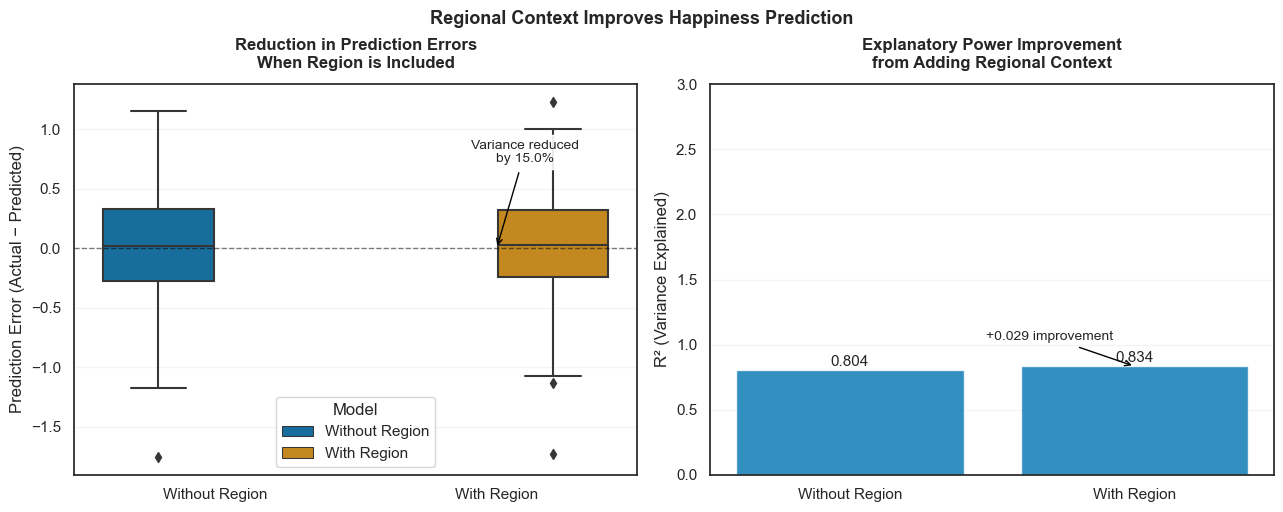

In [15]:
# Prepare response explicitly
y_clean = df_country_clean["Happiness"]

# Create dummy variables for region
df_with_dummies = pd.get_dummies(
    df_country_clean,
    columns=["Region"],
    drop_first=True
)

region_cols = [c for c in df_with_dummies.columns if c.startswith("Region_")]
X_with_region = df_with_dummies[PREDICTORS + region_cols]

# Fit model with region
model_with_region = LinearRegression().fit(X_with_region, y_clean)
r2_with_region = model_with_region.score(X_with_region, y_clean)

# Residuals
df_country_clean["Residual_Base"] = y_clean - model_base.predict(X)
df_country_clean["Residual_WithRegion"] = (
    y_clean - model_with_region.predict(X_with_region)
)

# Long format for boxplot
residuals_long = pd.melt(
    df_country_clean[["Residual_Base", "Residual_WithRegion"]],
    var_name="Model",
    value_name="Residual"
)

residuals_long["Model"] = residuals_long["Model"].replace({
    "Residual_Base": "Without Region",
    "Residual_WithRegion": "With Region"
})

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Plot 1: residual distributions
sns.boxplot(
    data=residuals_long,
    x="Model",
    y="Residual",
    hue="Model",
    ax=ax1,
)

ax1.axhline(0, color="black", linestyle="--", alpha=0.5, linewidth=1)
ax1.set_title(
    "Reduction in Prediction Errors\nWhen Region is Included",
    fontsize=12,
    fontweight="bold",
    pad=12
)
ax1.set_xlabel("")
ax1.set_ylabel("Prediction Error (Actual − Predicted)")
ax1.grid(True, axis="y", alpha=0.2)

# Variance reduction annotation
var_base = df_country_clean["Residual_Base"].var()
var_with_region = df_country_clean["Residual_WithRegion"].var()
var_reduction = (var_base - var_with_region) / var_base

ax1.annotate(
    f"Variance reduced\nby {var_reduction:.1%}",
    xy=(1, 0),
    xytext=(0.8, 0.8),
    textcoords="axes fraction",
    arrowprops=dict(arrowstyle="->", color="black"),
    fontsize=10,
    ha="center",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9)
)

# Plot 2: R² comparison
models = ["Without Region", "With Region"]
r2_values = [r2_base, r2_with_region]

bars = ax2.bar(models, r2_values, alpha=0.8)

# Bar Chart Title
ax2.set_title(
    "Explanatory Power Improvement\nfrom Adding Regional Context",
    fontsize=12,
    fontweight="bold",
    pad=12
)

# Label Limits
ax2.set_ylabel("R² (Variance Explained)")
ax2.set_ylim(0, 3)
ax2.grid(True, alpha=0.2, axis="y")

for bar, r2_val in zip(bars, r2_values):
    ax2.text(
        bar.get_x() + bar.get_width() / 2,
        r2_val + 0.01,
        f"{r2_val:.3f}",
        ha="center",
        va="bottom",
        fontsize=11
    )

# Annotation with arrow
improvement = r2_with_region - r2_base
ax2.annotate(
    f"+{improvement:.3f} improvement",
    xy=(1, r2_with_region),
    xytext=(0.7, r2_with_region + 0.2),
    arrowprops=dict(arrowstyle="->", color="black"),
    fontsize=10,
    ha="center"
)

plt.tight_layout()

# Main title
plt.suptitle(
    "Regional Context Improves Happiness Prediction",
    fontsize=13,
    fontweight="bold",
    y=1.02
)

# Save
save_fig("assets/rq1/rq1_step2_model_improvement.png")
plt.show()

##### RQ1 Conclusion

Research Question: Do countries within similar geographic regions show comparable happiness patterns beyond what is explained by economic and social factors?

**Answer: Yes, regional context matters.**

**Key Findings:**

1. **Systematic Regional Errors**
   The baseline model shows clear regional bias. For example, it consistently underestimates happiness in Europe and overestimates happiness in Asia.

2. **Improved Model Performance**
   Including regional information increases the model’s explanatory power (R²) from 0.804 to 0.834, representing a 4% improvement.

3. **Reduced Prediction Uncertainty**
   The variance of prediction errors decreases by approximately 15% when region is added, making forecasts more reliable.

**Interpretation:**
Countries within the same region report happiness in ways that go beyond economic and social indicators alone. Geographic context—including shared cultural, historical, and environmental factors—captures systematic influences on how people perceive and report their well-being.

## RQ2: Do key indicators affect happiness differently across world regions?

Analysis will be performed in 3 steps below

##### Step 1: How Happiness Factors Differ by Region?

Each plot shows how one factor connects to happiness in a specific region.

**Looking for:**
- Do these connections look similar across regions?
- Are certain factors stronger predictors in some parts of the world than others?

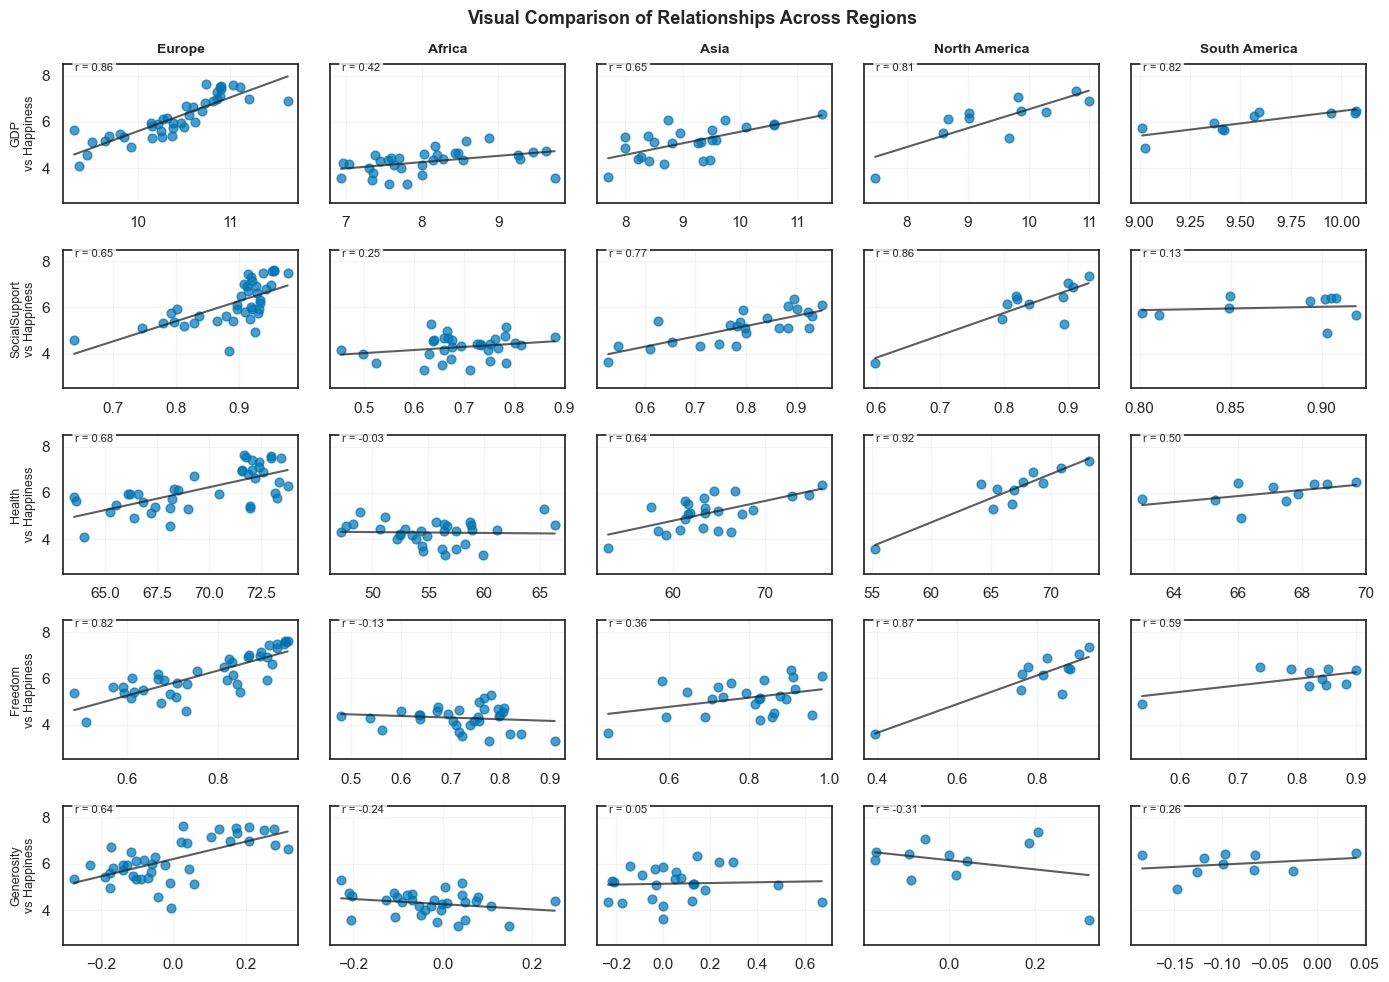

In [16]:
# Create a clean subset for analysis using shared constants
df_rq2 = df_country_clean[df_country_clean["Region"].isin(FOCUS_REGIONS)].copy()

# VISUAL 1: Side-by-side regional comparisons
fig, axes = plt.subplots(len(PREDICTORS), len(FOCUS_REGIONS), figsize=(14, 10), sharey=True)

# Display each plot
for row, predictor in enumerate(PREDICTORS):
    for col, region in enumerate(FOCUS_REGIONS):
        ax = axes[row, col]
        region_data = df_rq2[df_rq2["Region"] == region]

        if len(region_data) > 0:
            ax.scatter(region_data[predictor], region_data["Happiness"], alpha=0.7, s=40)

            if len(region_data) > 2:
                z = np.polyfit(region_data[predictor],region_data["Happiness"],1)
                p = np.poly1d(z)
                x_range = np.linspace(region_data[predictor].min(), region_data[predictor].max(), 100)
                ax.plot(x_range, p(x_range), "k-", alpha=0.7, linewidth=1.5)

            # Display R2 score
            corr = region_data[predictor].corr(region_data["Happiness"])
            ax.text(0.05,0.95, f"r = {corr:.2f}", transform=ax.transAxes, fontsize=8,
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

        # Display Y labels
        if col == 0:
            ax.set_ylabel(f"{predictor}\nvs Happiness", fontsize=9)
        else:
            ax.set_ylabel("")

        # Display X labels
        if row == 0:
            ax.set_title(region, fontsize=10, fontweight="bold", pad=8)

        ax.grid(True, alpha=0.2)
        ax.set_ylim(2.5, 8.5)

plt.suptitle("Visual Comparison of Relationships Across Regions", fontsize=13, fontweight="bold", y=0.98)
plt.tight_layout()
save_fig("assets/rq2/rq2_step1_grid_comparison.png")
plt.show()

**Step 2: How Strong Are the Connections in Each Region?**

This step quantifies how strongly each factor relates to happiness across regions.


Correlation Matrix (predictor × region):
Region         Africa  Asia  Europe  North America  South America
Predictor                                                        
Freedom         -0.13  0.36    0.82           0.87           0.59
GDP              0.42  0.65    0.86           0.81           0.82
Generosity      -0.24  0.05    0.64          -0.31           0.26
Health          -0.03  0.64    0.68           0.92           0.50
SocialSupport    0.25  0.77    0.65           0.86           0.13

(Values range from -1 to 1, higher = stronger relationship)


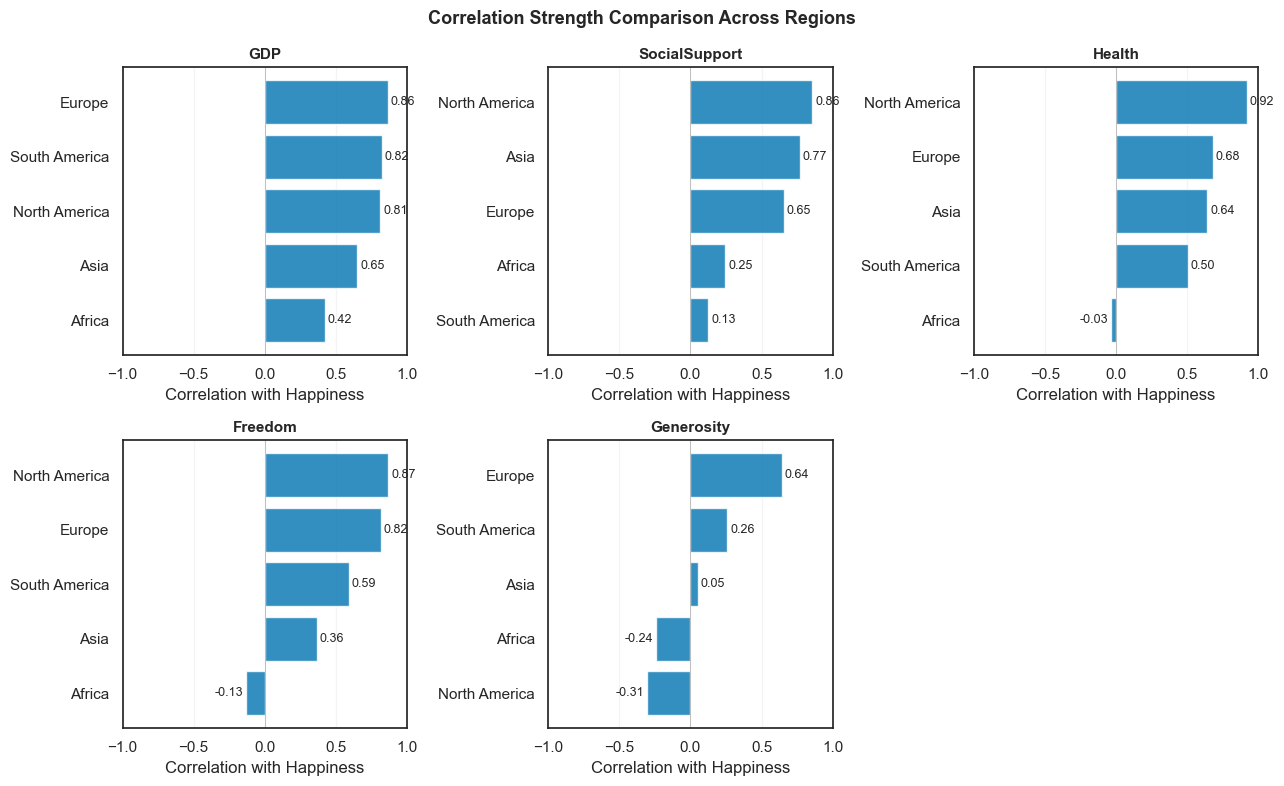

In [17]:
# RQ2 ANALYSIS - STEP 2: Quantitative Comparison
correlation_results = []

for region in FOCUS_REGIONS:
    region_data = df_rq2[df_rq2["Region"] == region]

    if len(region_data) >= 5:
        for predictor in PREDICTORS:
            corr = region_data[predictor].corr(region_data["Happiness"])
            correlation_results.append({
                "Region": region,
                "Predictor": predictor,
                "Correlation": corr,
                "N": len(region_data)
            })

corr_df = pd.DataFrame(correlation_results)
corr_pivot = corr_df.pivot_table(index="Predictor", columns="Region", values="Correlation", aggfunc="first")

print("\nCorrelation Matrix (predictor × region):")
print(corr_pivot.round(2).to_string())
print("\n(Values range from -1 to 1, higher = stronger relationship)")

# Plot 2: Correlation Strength Comparison
fig, axes = plt.subplots(2, 3, figsize=(13, 8))
axes = axes.flatten()

# Remove unused subplots
for ax in axes[len(PREDICTORS):]:
    fig.delaxes(ax)

for i, predictor in enumerate(PREDICTORS):
    ax = axes[i]

    pred_data = (
        corr_df[corr_df["Predictor"] == predictor]
        .sort_values("Correlation")
    )

    if len(pred_data) > 0:
        y_pos = range(len(pred_data))

        bars = ax.barh(
            y_pos,
            pred_data["Correlation"],
            alpha=0.8
        )

        ax.axvline(0, color="black", alpha=0.3, linewidth=0.5)
        ax.set_title(predictor, fontsize=11, fontweight="bold")
        ax.set_xlabel("Correlation with Happiness")
        ax.set_yticks(y_pos)
        ax.set_yticklabels(pred_data["Region"])
        ax.set_xlim(-1.0, 1.0)
        ax.grid(True, alpha=0.2, axis="x")

        for bar, row in zip(bars, pred_data.itertuples()):
            width = bar.get_width()
            ax.text(
                width + (0.02 if width > 0 else -0.02),
                bar.get_y() + bar.get_height() / 2,
                f"{row.Correlation:.2f}",
                va="center",
                ha="left" if width > 0 else "right",
                fontsize=9
            )

plt.suptitle("Correlation Strength Comparison Across Regions", fontsize=13, fontweight="bold", y=0.98)
plt.tight_layout()
save_fig("assets/rq2/rq2_step2_correlation_comparison.png")
plt.show()

##### Step 3: Correlation Heatmap

The heatmap provides a final, comprehensive view of regional patterns in happiness predictors. Color intensity indicates relationship strength, allowing quick identification of patterns.

Top factor per region:
          Region     Top_Factor
0         Africa            GDP
1           Asia  SocialSupport
2         Europe            GDP
3  North America         Health
4  South America            GDP


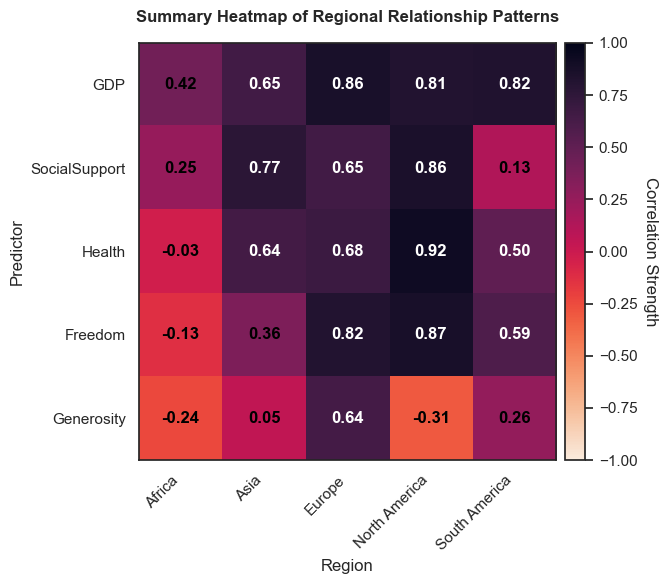

In [18]:
# Summary Heatmap
fig, ax = plt.subplots(figsize=(9, 6))

# Ensure correct predictor order
corr_heatmap = corr_pivot.loc[PREDICTORS]

# Derive top factor per region from RQ2 correlations
top_df = (
    corr_pivot
    .abs()                               # importance = magnitude
    .idxmax(axis=0)                     # top predictor per region
    .reset_index()
)

top_df.columns = ["Region", "Top_Factor"]

print("Top factor per region:")
print(top_df)

# Mask missing values (optional but robust)
masked = np.ma.masked_invalid(corr_heatmap.values)

# Plot heatmap
im = ax.imshow(masked, cmap="rocket_r", vmin=-1, vmax=1)

# Add text annotations
for i in range(len(corr_heatmap)):
    for j in range(len(corr_heatmap.columns)):
        value = corr_heatmap.iloc[i, j]
        if not pd.isna(value):
            color = "white" if abs(value) > 0.5 else "black"
            ax.text(
                j, i, f"{value:.2f}",
                ha="center", va="center",
                color=color, fontweight="bold"
            )

# Labels
ax.set_xticks(range(len(corr_heatmap.columns)))
ax.set_xticklabels(corr_heatmap.columns, rotation=45, ha="right")
ax.set_yticks(range(len(corr_heatmap.index)))
ax.set_yticklabels(corr_heatmap.index)

ax.set_title(
    "Summary Heatmap of Regional Relationship Patterns",
    fontsize=12, fontweight="bold", pad=15
)
ax.set_xlabel("Region")
ax.set_ylabel("Predictor")

# Colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.01)
cbar.set_label("Correlation Strength", rotation=270, labelpad=15)

plt.tight_layout()
save_fig("assets/rq2/rq2_step3_summary_heatmap.png")
plt.show()

**RQ2: Yes, happiness factors work differently by region.**

**Key Differences:**
- **Social Support** → matters everywhere
- **Freedom** → matters more in some regions than others
- **Generosity** → weak link everywhere

## RQ3: Are there regions that consistently report higher or lower happiness than their economic conditions would suggest?

Analysis will be performed in 3 steps below

##### Step 1. Countrywide Prediction
Will be checked if countries performing as expected

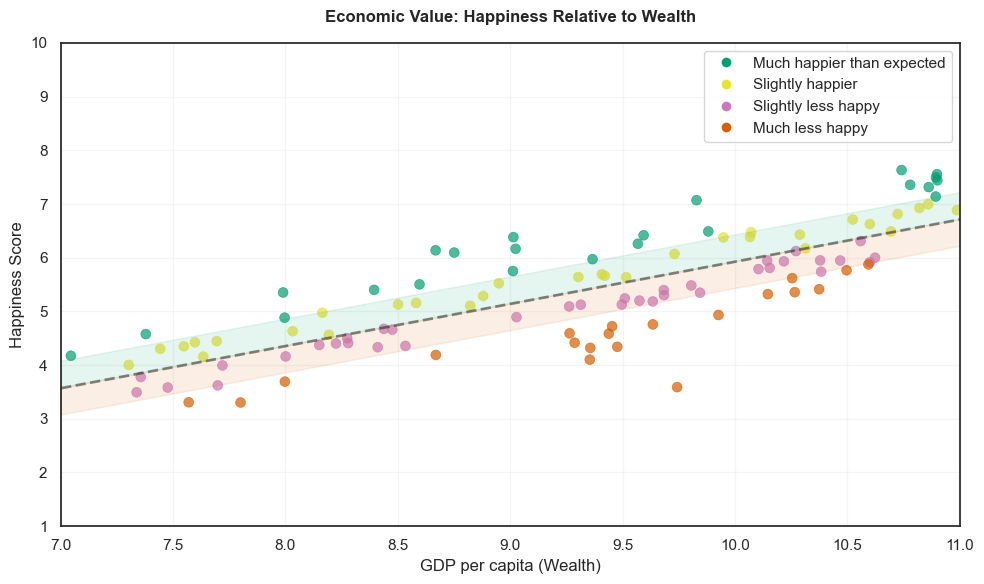

In [19]:
# Fit model using ONLY GDP (economic conditions)
X_gdp = df_country_clean[["GDP"]]
y = df_country_clean["Happiness"]

model_gdp_only = LinearRegression().fit(X_gdp, y)
r2_gdp_only = model_gdp_only.score(X_gdp, y)

# Calculate economic-specific residuals
df_country_clean["Predicted_GDP"] = model_gdp_only.predict(X_gdp)
df_country_clean["Residual_GDP"] = df_country_clean["Happiness"] - df_country_clean["Predicted_GDP"]

# Prepare focus data
df_rq3 = df_country_clean[df_country_clean["Region"].isin(FOCUS_REGIONS)].copy()

# Plot 
fig, ax = plt.subplots(figsize=(10, 6))

x_vals = np.linspace(df_rq3["GDP"].min(), df_rq3["GDP"].max(), 100)
x_pred = pd.DataFrame({"GDP": x_vals})
y_vals = model_gdp_only.predict(x_pred)

ax.plot(
    x_vals, y_vals,
    'k--', alpha=0.5, linewidth=2,
    label=f'Expected by wealth (R²={r2_gdp_only:.2f})'
)

# Color points by economic over/under-performance
colors = df_rq3["Residual_GDP"].apply(
    lambda x: "#029e73" if x > 0.5 else
              "#ece133" if x > 0 else
              "#cc78bc" if x > -0.5 else
              "#d55e00"
)
ax.scatter(df_rq3["GDP"], df_rq3["Happiness"], c=colors, alpha=0.7, s=50, linewidth=0.5)

# Performance zones
ax.fill_between(x_vals, y_vals, y_vals + 0.5, alpha=0.1, color='#029e73',
                label='Happier than wealth predicts')
ax.fill_between(x_vals, y_vals - 0.5, y_vals, alpha=0.1, color='#d55e00',
                label='Less happy than wealth predicts')

ax.set_xlabel("GDP per capita (Wealth)")
ax.set_ylabel("Happiness Score")
ax.set_title("Economic Value: Happiness Relative to Wealth", fontsize=12, fontweight="bold", pad=15)
ax.grid(True, alpha=0.2)
ax.set_ylim(1, 10)
ax.set_xlim(7, 11)

# Legend for performance colours
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#029e73', markersize=8, label='Much happier than expected'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ece133', markersize=8, label='Slightly happier'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#cc78bc', markersize=8, label='Slightly less happy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#d55e00', markersize=8, label='Much less happy')
]

ax.legend(handles=handles, loc='upper right')
plt.tight_layout()
save_fig("assets/rq3/rq3_part1_analysis.png")
plt.show()

##### Step 2

Regional Predictions

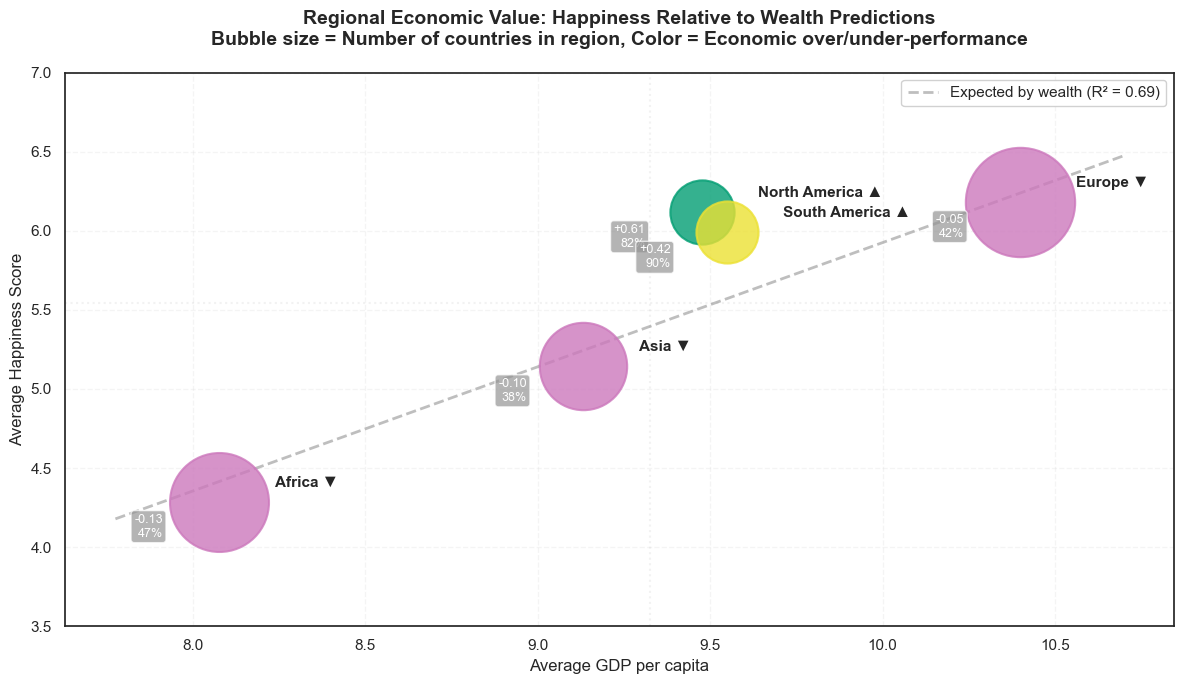

In [20]:
# Regional aggregation
region_agg = (
    df_rq3
    .groupby("Region", as_index=False)
    .agg(
        Avg_GDP=("GDP", "mean"),
        Avg_Happiness=("Happiness", "mean"),
        Performance_Gap=("Residual_GDP", "mean"),
        Percent_Overperforming=("Residual_GDP", lambda x: (x > 0).mean() * 100),
        N_Countries=("Country", "count")
    )
)

# Color regions by economic over/under-performance
region_agg["Color"] = region_agg["Performance_Gap"].apply(
    lambda x: "#029e73" if x > 0.5 else
              "#ece133" if x > 0 else
              "#cc78bc" if x > -0.5 else
              "#d55e00"
)

fig, ax = plt.subplots(figsize=(12, 7))

# Bubble size & label offsets
bubble_sizes = 600 + region_agg["N_Countries"] * 140
x_offset = (region_agg["Avg_GDP"].max() - region_agg["Avg_GDP"].min()) * 0.07
y_offset = (region_agg["Avg_Happiness"].max() - region_agg["Avg_Happiness"].min()) * 0.04

# Bubble plot with clean annotations
for _, row in region_agg.iterrows():

    # Bubble
    ax.scatter(
        row["Avg_GDP"],
        row["Avg_Happiness"],
        s=600 + row["N_Countries"] * 140,
        color=row["Color"],
        alpha=0.80,
        linewidth=1.5,
        zorder=3
    )

    # Direction symbol
    symbol = "▲" if row["Performance_Gap"] > 0 else "▼"

    # Region label (top-right)
    ax.text(
        row["Avg_GDP"] + x_offset,
        row["Avg_Happiness"] + y_offset, f"{row['Region']} {symbol}", ha="left", va="bottom",fontsize=11,fontweight="bold",zorder=4)

    # Performance details (bottom-left)
    ax.text(
        row["Avg_GDP"] - x_offset,
        row["Avg_Happiness"] - y_offset,
        f"{row['Performance_Gap']:+.2f}\n{row['Percent_Overperforming']:.0f}%",
        ha="right",
        va="top",
        fontsize=9,
        bbox=dict( boxstyle="round,pad=0.25", alpha=0.7, facecolor="#949494"), zorder=4, color="white")

# GDP-only expected trend line
x_range = np.linspace(region_agg["Avg_GDP"].min() - 0.3, region_agg["Avg_GDP"].max() + 0.3, 200)
x_df = pd.DataFrame({"GDP": x_range})
y_expected = model_gdp_only.predict(x_df)

ax.plot(x_range, y_expected, linestyle="--", linewidth=2, color="#949494", alpha=0.6, label=f"Expected by wealth (R² = {r2_gdp_only:.2f})", zorder=2)

# Reference lines
ax.axhline(region_agg["Avg_Happiness"].mean(), color="gray", linestyle=":", alpha=0.1)
ax.axvline(region_agg["Avg_GDP"].mean(), color="gray", linestyle=":",alpha=0.1)

# Final formatting
ax.set_xlabel("Average GDP per capita", fontsize=12)
ax.set_ylabel("Average Happiness Score", fontsize=12)

ax.set_ylim(3.5, 7)

ax.set_title(
    "Regional Economic Value: Happiness Relative to Wealth Predictions\n"
    "Bubble size = Number of countries in region, Color = Economic over/under-performance",
    fontsize=14,
    fontweight="bold",
    pad=20
)

ax.grid(True, alpha=0.2, linestyle="--")
ax.legend(frameon=True, framealpha=0.9)

plt.tight_layout()
save_fig("assets/rq3/rq3_part2_analysis.png")
plt.show()

##### Step 3

Summary plot: Economic Performance

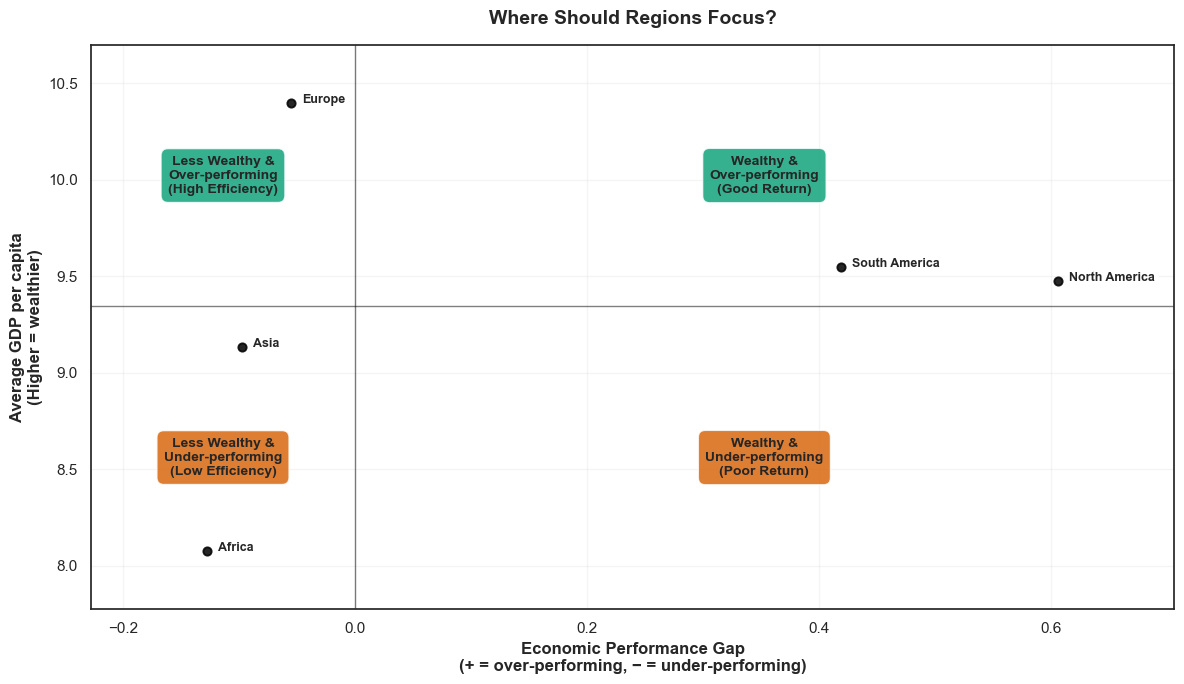

Wealth alone explains only 68.9% of happiness variation


In [21]:
# Precompute references
gdp_mean = df_rq3["GDP"].mean()

x_min, x_max = (region_agg["Performance_Gap"].min() - 0.1,region_agg["Performance_Gap"].max() + 0.1)
y_min, y_max = (region_agg["Avg_GDP"].min() - 0.3, region_agg["Avg_GDP"].max() + 0.3)
fig, ax = plt.subplots(figsize=(12, 7))

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Reference axes
ax.axhline(gdp_mean, color="black", alpha=0.5, linewidth=1)
ax.axvline(0, color="black", alpha=0.5, linewidth=1)

# Plot regions
for _, row in region_agg.iterrows():
    ax.scatter(
        row["Performance_Gap"],
        row["Avg_GDP"],
        color="black",
        alpha=0.85,
        linewidth=1.3,
        zorder=3)

    ax.annotate(
        row["Region"],
        (row["Performance_Gap"], row["Avg_GDP"]),
        xytext=(8, 0),
        textcoords="offset points",
        fontsize=9,
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),
        zorder=4)

# Quadrant labels (stable placement)
x_mid_left = x_min + (0 - x_min) * 0.5
x_mid_right = 0 + (x_max - 0) * 0.5
y_mid_low = y_min + (gdp_mean - y_min) * 0.5
y_mid_high = gdp_mean + (y_max - gdp_mean) * 0.5

ax.text(
    x_mid_left, y_mid_high,
    "Less Wealthy &\nOver-performing\n(High Efficiency)",
    ha="center", va="center",
    fontsize=10, fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="#029e73", alpha=0.8))

ax.text(
    x_mid_right, y_mid_high,
    "Wealthy &\nOver-performing\n(Good Return)",
    ha="center", va="center",
    fontsize=10, fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="#029e73", alpha=0.8))

ax.text(
    x_mid_left, y_mid_low,
    "Less Wealthy &\nUnder-performing\n(Low Efficiency)",
    ha="center", va="center",
    fontsize=10, fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="#d55e00", alpha=0.8))

ax.text(
    x_mid_right, y_mid_low,
    "Wealthy &\nUnder-performing\n(Poor Return)",
    ha="center", va="center",
    fontsize=10, fontweight="bold",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="#d55e00", alpha=0.8))

# Final formatting
ax.set_xlabel("Economic Performance Gap\n(+ = over-performing, − = under-performing)",fontsize=12, fontweight="bold")
ax.set_ylabel("Average GDP per capita\n(Higher = wealthier)", fontsize=12, fontweight="bold")
ax.set_title("Where Should Regions Focus?", fontsize=14, fontweight="bold", pad=15)
ax.grid(True, alpha=0.2)

plt.tight_layout()
save_fig("assets/rq3/rq3_part3_summary.png")
plt.show()

print(f"Wealth alone explains only {r2_gdp_only:.1%} of happiness variation")